## TP Climate Finance

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

In [40]:
df_stock=pd.read_excel("Individual_stock_data.xlsx",sheet_name='stock prices').dropna(axis=1)
df_stock=df_stock.set_index('Date')
df_stock.index=pd.to_datetime(df_stock.index)
df_carbonfootprint=pd.read_excel("Individual_stock_data.xlsx",sheet_name='carbon footprint data',skiprows=20,nrows=1,
names=['NAME','SECTOR','SECTOR_NAME','SCOPE1','SCOPE2','EMISSIONS','MARKET_VALUE','REVENUES','CARBON_FOOTPRINT','INTENSITY'])
df_sp=pd.read_excel('Individual_stock_data.xlsx',sheet_name='SP500')
df_sp=df_sp.set_index('Name')

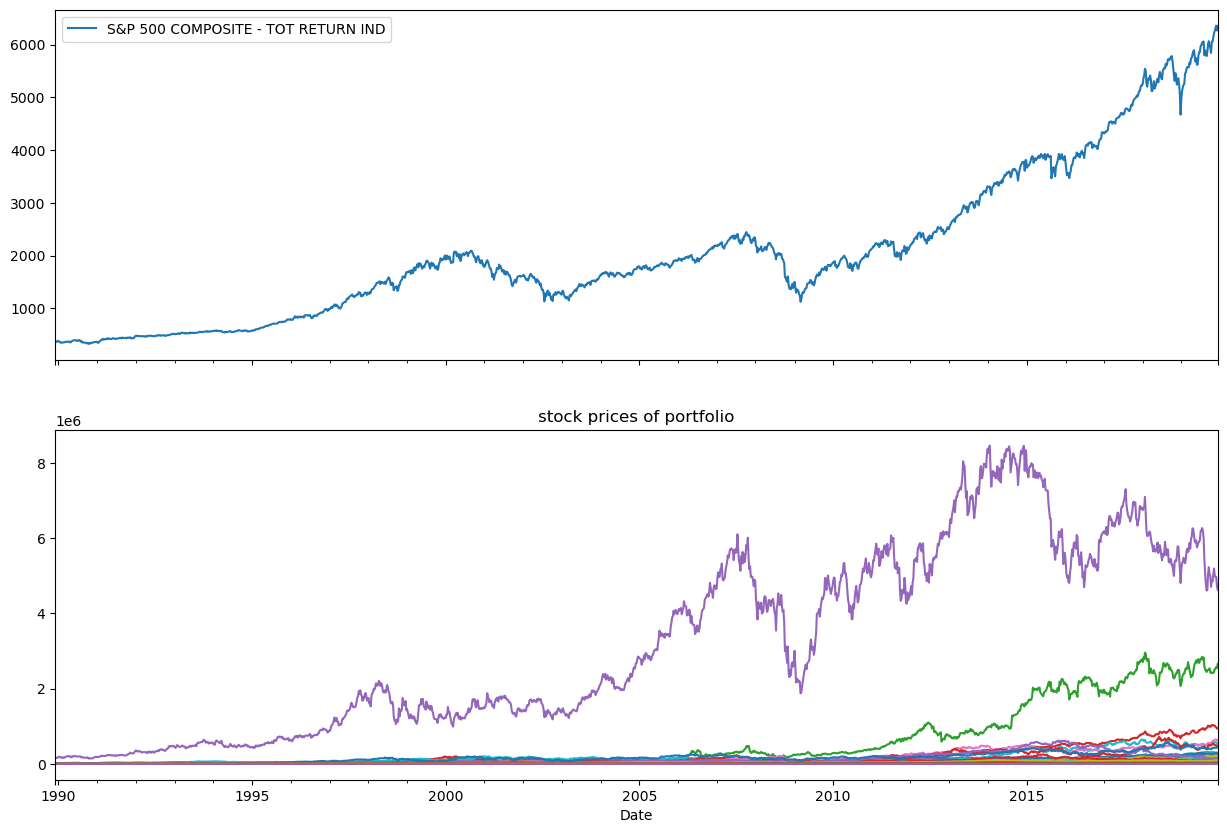

In [3]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
df_sp.plot(ax=ax[0])
df_stock.plot(ax=ax[1],legend=False,title='stock prices of portfolio')
plt.show()

Weight search by minimizing tracking error

In [51]:
def add_return(df):
    iduree=[i for i in range(len(df_stock.index))]
    del iduree[0]
    df=df.copy()
    columns=[f'Return {c}' for c in df_stock.columns]
    dfr=pd.DataFrame(np.zeros((len(df.index),len(columns))),columns=columns)
    for c in df.columns :
        for i in iduree :
            dfr.loc[i,f'Return {c}']=(df.loc[df.index[i],c]-df.loc[df.index[i]-np.timedelta64(7, 'D'),c])/df.loc[df.index[i],c]
        dfr.loc[0,f'Return {c}']=0
    dfr.index=df.index
    return pd.concat([df,dfr],axis=1)

In [52]:
df_stock=add_return(df_stock)

In [69]:
intervalle0=df_stock.index[(df_stock.index < '1993-01-01')]
T=len(intervalle0)
NbT=int(len(df_stock)/T)+1

In [70]:
def Intervalle(i):
    I=df_stock.index[(df_stock.index < '1993-01-01')]
    if i==10:
        I=df_stock.index[(df_stock.index > Intervalle(9).max())]
    if 0<i<NbT:
        I=df_stock.index[(df_stock.index > Intervalle(i-1).max())&(df_stock.index < Intervalle(i-1).max()+np.timedelta64(T, 'W'))]
    return I

In [ ]:
#ne marche pas
# lw=[]
# for i in range(NbT):
#     model=gp.Model()
#     model.Params.LogToConsole = 0
#     w=model.addVar(vtype=gp.GRB.CONTINUOUS)
    
#     model.setObjective(gp.quicksum(w*df_stock.loc[t,c]-df_sp.loc[t,:] for t in Intervalle(i) for c in df_stock.columns[int(len(df_stock.columns)/2):])**2/T,gp.GRB.MINIMIZE)
#     model.update()
#     model.optimize()
#     lw.append(w.x)